# Analyzing CITE-seq data

**Author:** Isaac Virshup

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sc.logging.print_versions()
sc.set_figure_params(frameon=False, figsize=(4, 4))

scanpy==1.4.5.2.dev48+g5c81890 anndata==0.7.2.dev24+g669dd44 umap==0.4.0rc1 numpy==1.16.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


## Reading

In [4]:
# !mkdir -p data
# !wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 -O data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5

In [5]:
datafile = "data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"

In [6]:
pbmc = sc.read_10x_h5(datafile, gex_only=False)
pbmc.var_names_make_unique()
pbmc.layers["counts"] = pbmc.X.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Inspect the full object.

In [7]:
pbmc

AnnData object with n_obs × n_vars = 5527 × 33570 
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

Inspect the number of variables for the two different modalities.

In [8]:
pbmc.var["feature_types"].value_counts()

Gene Expression     33538
Antibody Capture       32
Name: feature_types, dtype: int64

## Preprocessing

For ease of preprocessing, we'll split the data into seperate protein and RNA `AnnData` objects:

In [9]:
protein = pbmc[:, pbmc.var["feature_types"] == "Antibody Capture"].copy()
rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()

### Protein

First we'll take a look at the antibody counts.

We still need to explain the function here. I'm happy if we add it to the first tutorial, too (I know you did it already at some point, but I didn't want to let go of the simpler naming scheme back then; now I'd be happy to transition.)

Inspect the proteins stored. Some of them are merge control measurements.

Most of them are protein markers associated with T cell activity. CD8 marks cytotoxicity, PD-1 and TIGIT mark dysfunctional T cell states.

In [10]:
print(protein.var_names.tolist())

['CD3_TotalSeqB', 'CD4_TotalSeqB', 'CD8a_TotalSeqB', 'CD11b_TotalSeqB', 'CD14_TotalSeqB', 'CD15_TotalSeqB', 'CD16_TotalSeqB', 'CD19_TotalSeqB', 'CD20_TotalSeqB', 'CD25_TotalSeqB', 'CD27_TotalSeqB', 'CD28_TotalSeqB', 'CD34_TotalSeqB', 'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB', 'CD56_TotalSeqB', 'CD62L_TotalSeqB', 'CD69_TotalSeqB', 'CD80_TotalSeqB', 'CD86_TotalSeqB', 'CD127_TotalSeqB', 'CD137_TotalSeqB', 'CD197_TotalSeqB', 'CD274_TotalSeqB', 'CD278_TotalSeqB', 'CD335_TotalSeqB', 'PD-1_TotalSeqB', 'HLA-DR_TotalSeqB', 'TIGIT_TotalSeqB', 'IgG1_control_TotalSeqB', 'IgG2a_control_TotalSeqB', 'IgG2b_control_TotalSeqB']


Let's compute some qc metrics.

In [11]:
protein.var["control"] = protein.var_names.str.contains("control")
sc.pp.calculate_qc_metrics(
    protein,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    qc_vars=("control",),
    inplace=True,
)

 We can look check out the qc metrics for our data:
 
 **TODO**: I would like to include some justification for the change in normalization. It definitley has a much different distribution than transcripts. I think this could be shown through the qc plots, but it's a huge pain to move around these matplotlib plots. This might be more appropriate for the in-depth guide though.
 
Agreed! But, having an explanation of the two images below is also a good first step. Also nice to contrast it with the corresponding RNA distributions. 

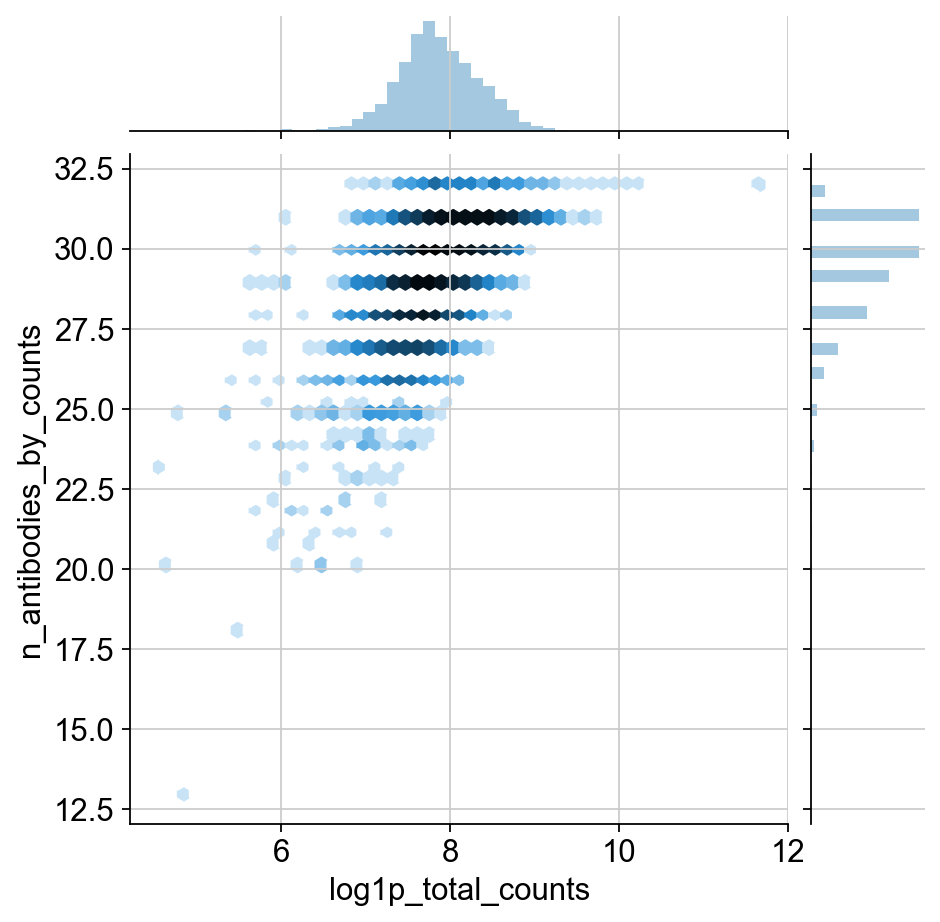

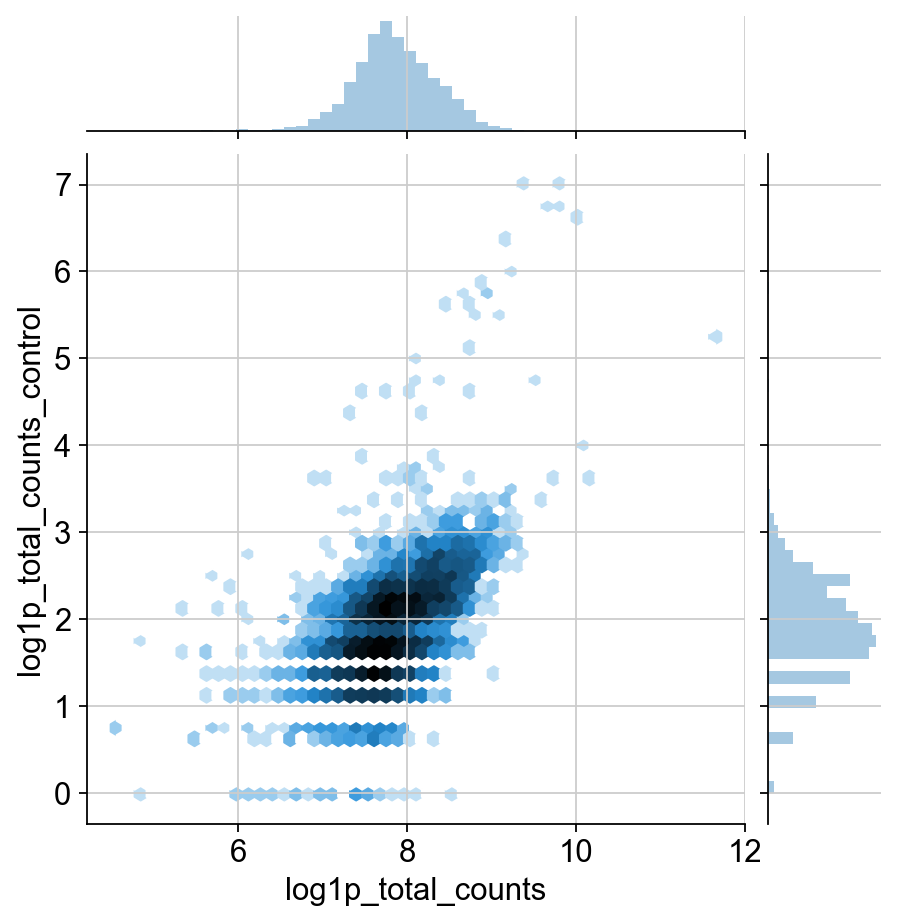

In [12]:
sns.jointplot("log1p_total_counts", "n_antibodies_by_counts", protein.obs, kind="hex", norm=mpl.colors.LogNorm())
sns.jointplot("log1p_total_counts", "log1p_total_counts_control", protein.obs, kind="hex", norm=mpl.colors.LogNorm())

In [13]:
protein.layers["counts"] = protein.X.copy()

Discuss that this here is a different normalization.

In [14]:
sc.pp.normalize_geometric(protein)
sc.pp.log1p(protein)

In [15]:
sc.pp.pca(protein, n_comps=20) # we just have 32 proteins, so a low numnber of PCs is appropriate to denoise this
sc.pp.neighbors(protein, n_neighbors=30)

/Users/alexwolf/repos/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alexwolf/repos/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alexwolf/repos/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


### RNA

Now we'll process our RNA in the typical way:

In [17]:
sc.pp.filter_genes(rna, min_counts=1)
rna.var["mito"] = rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(rna, qc_vars=["mito"], inplace=True)

Yes, would be great to the see the QC plots, here, too. Are cells with low counts etc. weird only on the RNA level or also on the protein level? It'd be nice to see the QC plots side-by-side between RNA and protein, I'd say.

In [18]:
rna.layers["counts"] = rna.X.copy()

In [19]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [20]:
sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=30)   # again, using higher than default numbers of neighbors stabilizes the layout

/Users/alexwolf/repos/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alexwolf/repos/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


## Joint manifold and clustering

In [25]:
def average_graphs(graphs, weights=None):
    """Take the maximum edge value from each graph.
    
    graphs : iterable of sparse matrices
    weights : iterable of floats with same length as graphs
    """
    if weights is None:
        weights = [1 for g in graphs]    
    if len(graphs) != len(weights):
        raise ValueError('graphs and weights need to have the same lenghts')
    out = weights[0] * graphs[0].copy()
    for i in range(1, len(graphs)):
        out += weights[i] * graphs[i]
    out /= sum(weights)
    return out

In [34]:
joint = rna.copy()

In [35]:
joint.obsm['protein'] = protein.to_df()

In [36]:
joint.uns['neighbors'] = {}
joint.uns['neighbors']['connectivities'] = average_graphs([rna.uns['neighbors']['connectivities'], protein.uns['neighbors']['connectivities']])

/Users/alexwolf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  


There are almost no *exactly* shared neighbors.

In [37]:
print(rna.uns['neighbors']['connectivities'].nnz)
print(protein.uns['neighbors']['connectivities'].nnz)
print(joint.uns['neighbors']['connectivities'].nnz)

245592
238364
458524


/Users/alexwolf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  """Entry point for launching an IPython kernel.
/Users/alexwolf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  
/Users/alexwolf/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/alexwolf/repos/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/alexwolf/repos/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alexwolf/repos/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
... storing 'feature_types' as categorical
... storing 'genome' as categorical


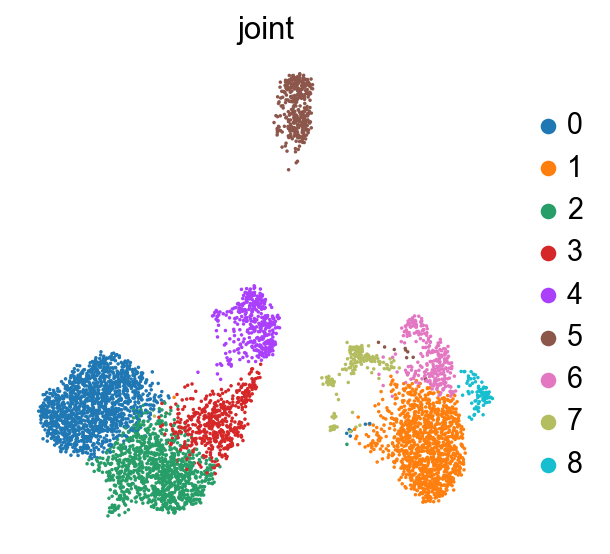

In [39]:
sc.tl.umap(joint)
sc.tl.leiden(joint, key_added='joint')
sc.tl.umap(joint)
sc.pl.umap(joint, color='joint', size=10)

## Comparing with an analysis of separate objects

In [53]:
sc.tl.leiden(protein, key_added="protein")
sc.tl.umap(protein)
sc.tl.leiden(rna, key_added="rna")
sc.tl.umap(rna)

/Users/alexwolf/repos/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alexwolf/repos/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/alexwolf/repos/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alexwolf/repos/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .o

Map onto joint.

In [46]:
joint.obs['protein'] = protein.obs['protein']
joint.obs['rna'] = rna.obs['rna']

In [57]:
rna.obs['protein'] = protein.obs['protein']
rna.obs['joint'] = joint.obs['joint']

In [60]:
protein.obs['rna'] = rna.obs['rna']
protein.obs['joint'] = joint.obs['joint']

joint umap


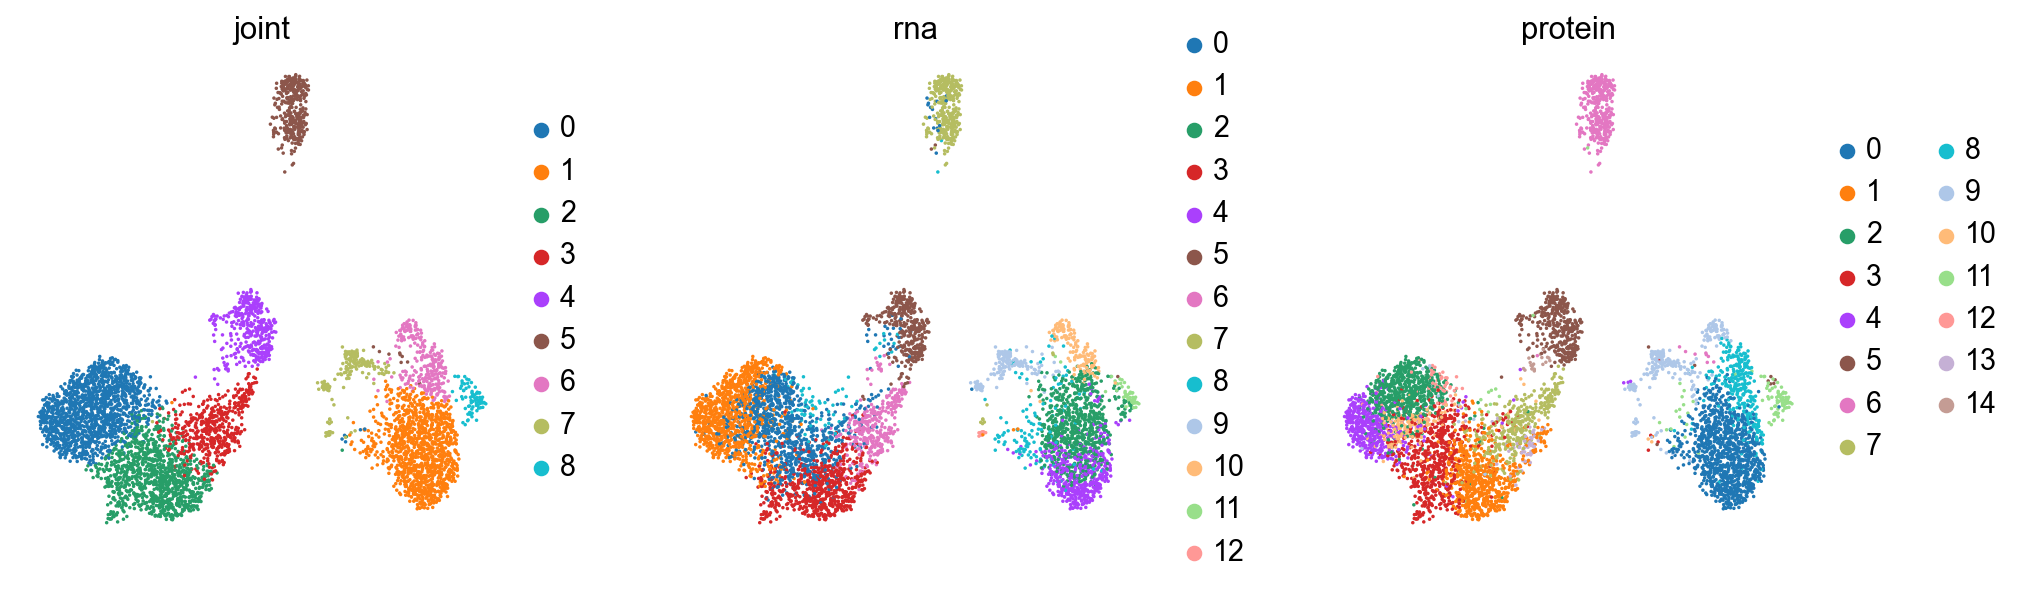

rna umap


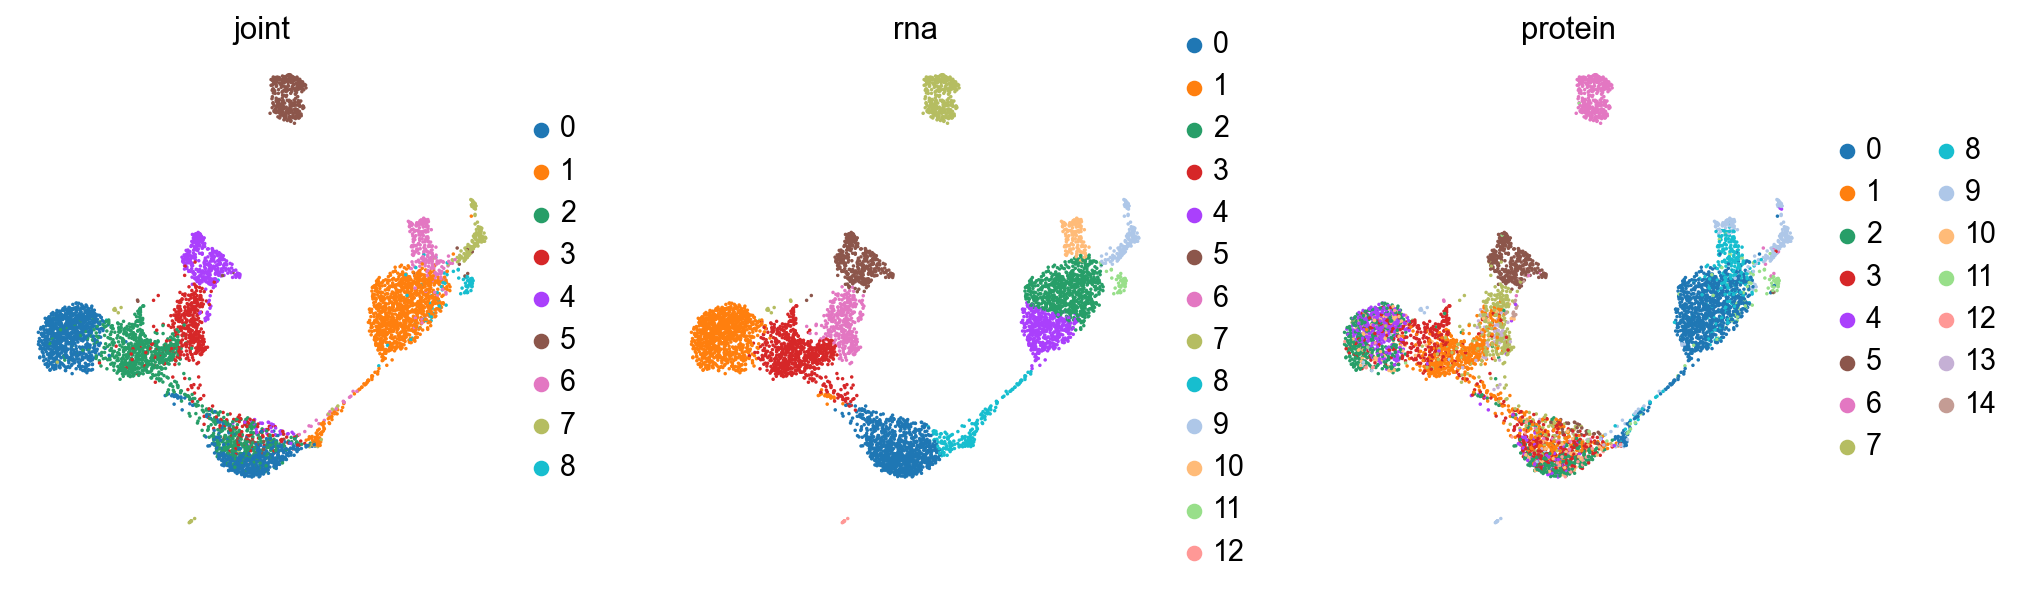

protein umap


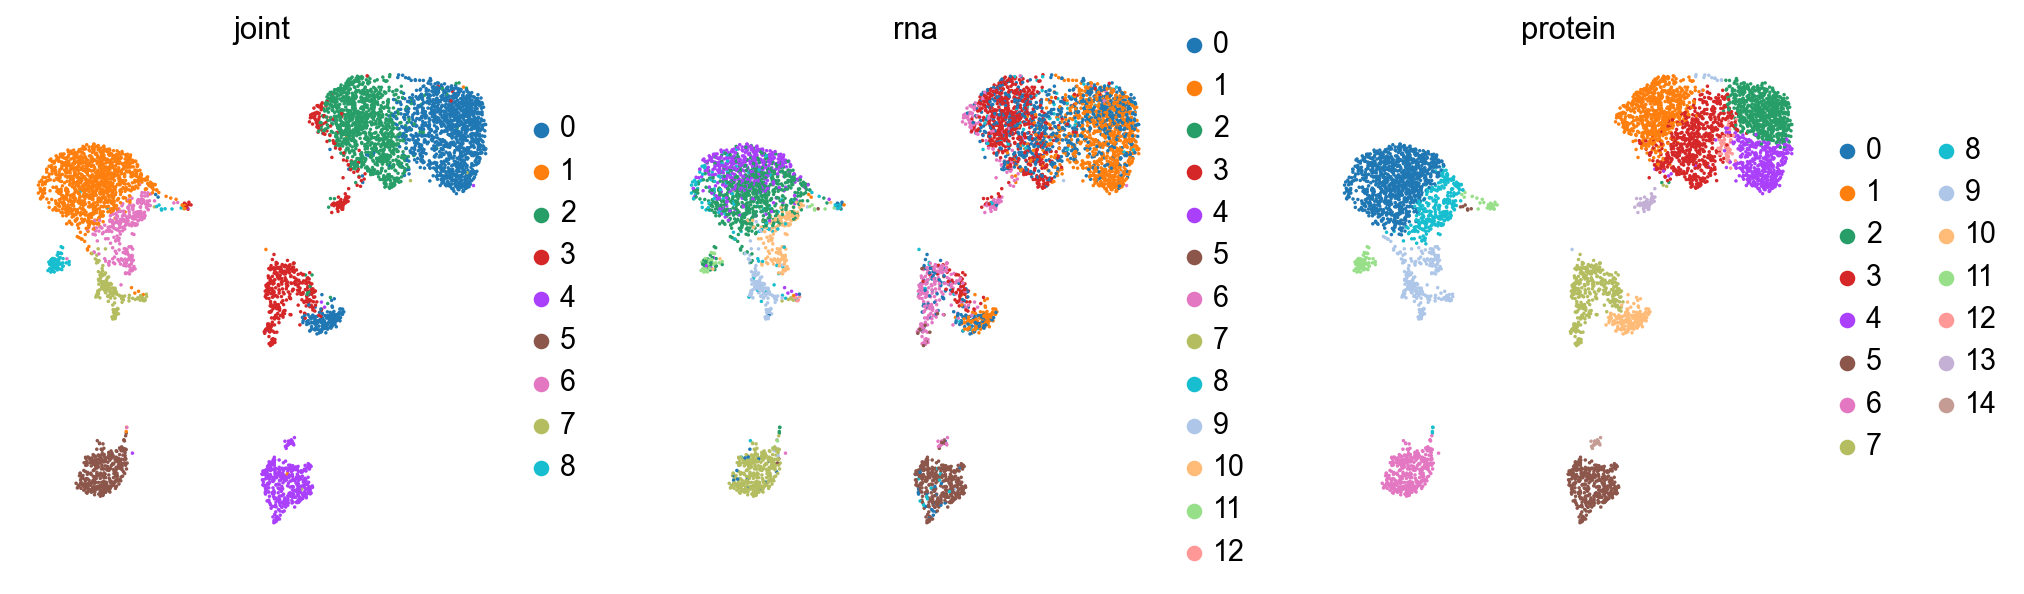

In [63]:
print('joint umap')
sc.pl.umap(joint, color=['joint', 'rna', 'protein'], size=10)
print('rna umap')
sc.pl.umap(rna, color=['joint', 'rna', 'protein'], size=10)
print('protein umap')
sc.pl.umap(protein, color=['joint', 'rna', 'protein'], size=10)

Plot some interesting markers, here.

In [56]:
# sc.pl.umap(joint, color=['CD8'], size=10)

## Visualization

An alternative would be to recombine the data into the `pbmc` object here.

In [19]:
rna.obsm["protein"] = protein.to_df()
rna.obsm["protein_umap"] = protein.obsm["X_umap"]
rna.obs["protein_leiden"] = protein.obs["protein_leiden"]
rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]

In [20]:
sc.tl.umap(rna)

/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


... storing 'feature_types' as categorical
... storing 'genome' as categorical


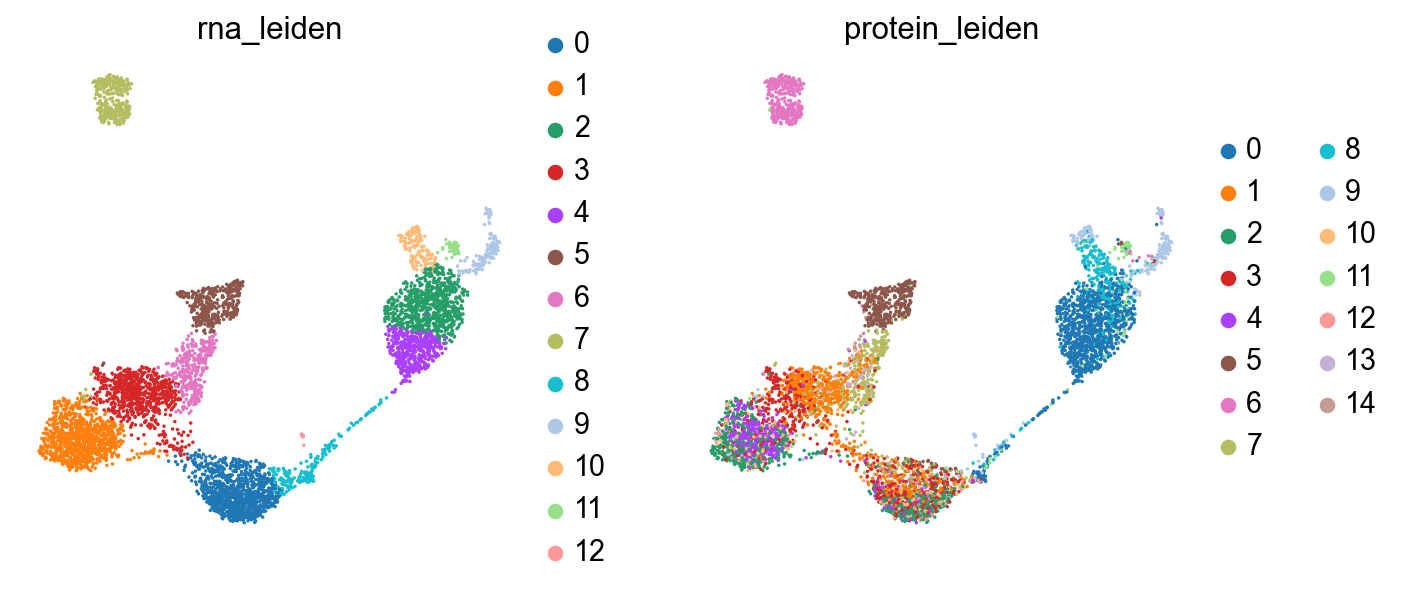

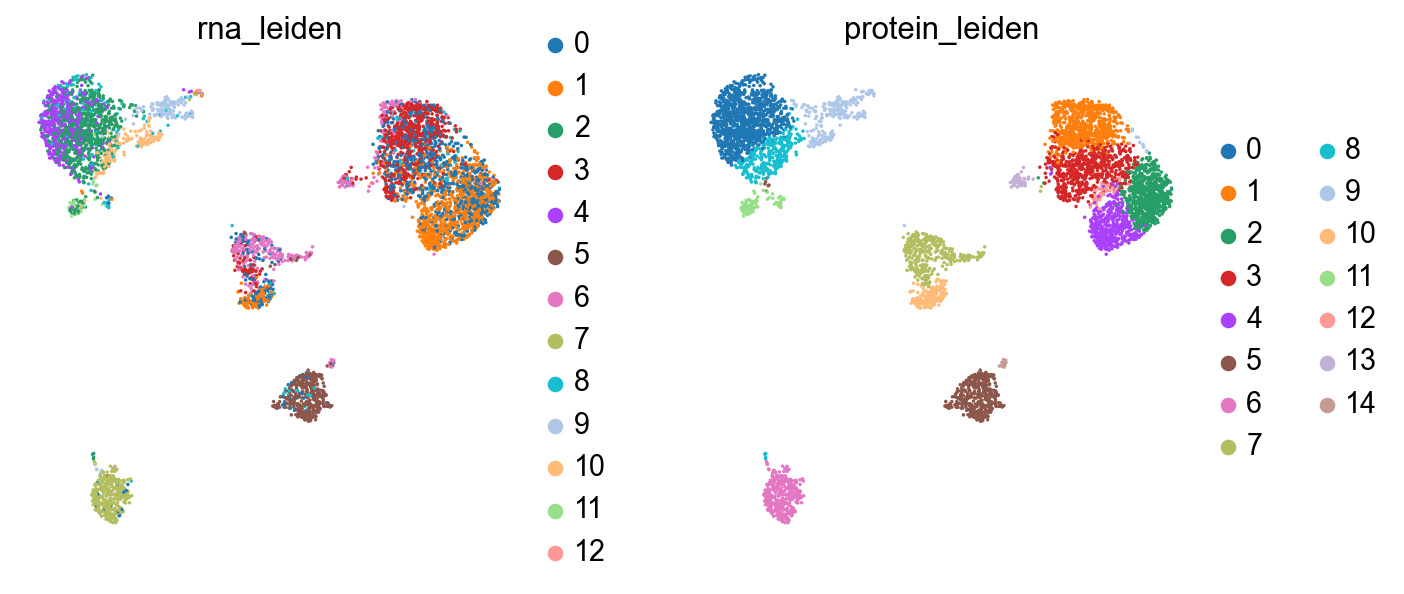

In [21]:
sc.pl.umap(rna, color=["rna_leiden", "protein_leiden"], size=10)
sc.pl.embedding(rna, basis="protein_umap", color=["rna_leiden", "protein_leiden"], size=10)

The clusterings disagree quite a bit. It looks like neither modality is giving a full accounting of the data, so now we'll see what we can learn by combining the modalities.

### Plotting values between modalities

* TODO: Get selectors like this working in scanpy.

### Imports and helper functions

In [22]:
import altair as alt
from functools import partial

alt.renderers.enable("png")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [23]:
def embedding_chart(df: pd.DataFrame, coord_pat: str, *, size=5) -> alt.Chart:
    """Make schema for coordinates, like sc.pl.embedding."""
    x, y = df.columns[df.columns.str.contains(coord_pat)]
    return (
        alt.Chart(plotdf, height=300, width=300)
        .mark_circle(size=size)
        .encode(
            x=alt.X(x, axis=None),
            y=alt.Y(y, axis=None),
        )
    )

def umap_chart(df: pd.DataFrame, **kwargs) -> alt.Chart:
    """Like sc.pl.umap, but just the coordinates."""
    return embedding_chart(df, "umap", **kwargs)

def encode_color(c: alt.Chart, col: str, *, qdomain=(0, 1), scheme: str = "lightgreyred") -> alt.Chart:
    """Add colors to an embedding plot schema."""
    base = c.properties(title=col)
    if pd.api.types.is_categorical(c.data[col]):
        return base.encode(color=col)
    else:
        return base.encode(
            color=alt.Color(
                col,
                scale=alt.Scale(
                    scheme=scheme,
                    clamp=True,
                    domain=list(c.data[col].quantile(qdomain)),
                    nice=True,
                )
            )
        )

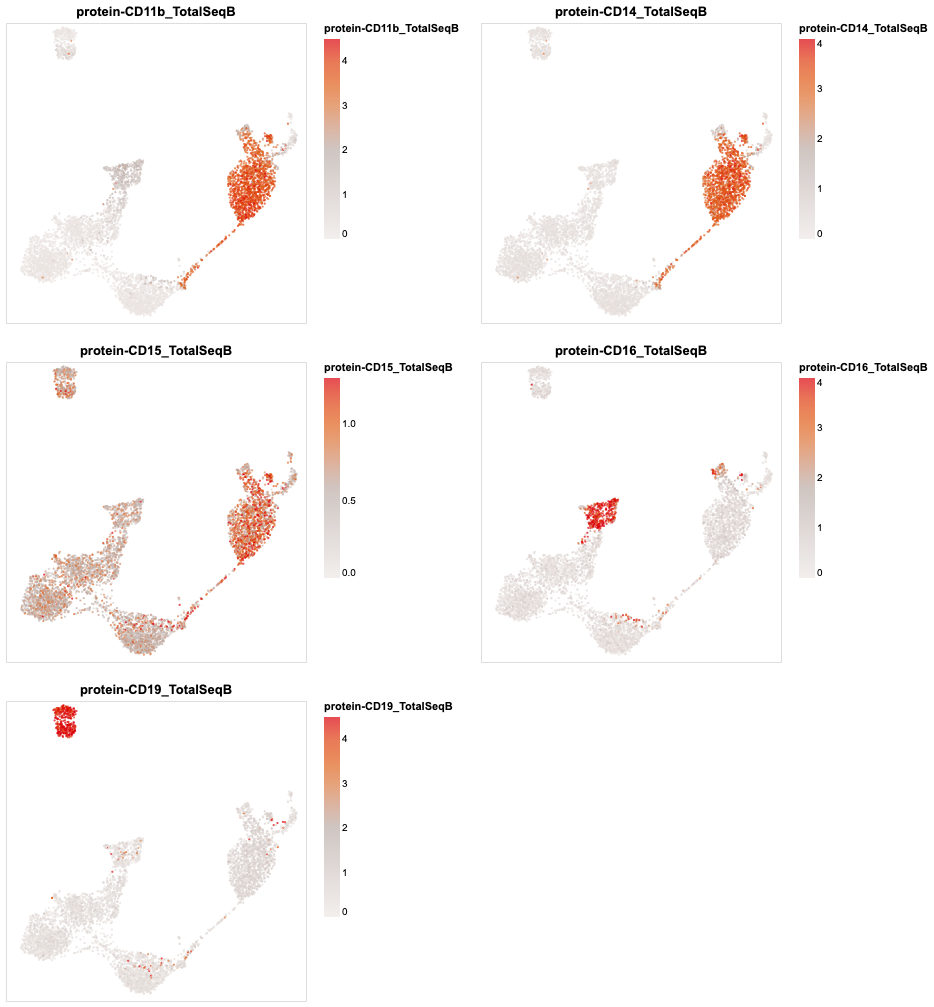

In [24]:
plotdf = sc.get.obs_df(
    rna,
    obsm_keys=[("X_umap", i) for i in range(2)] + [("protein", i) for i in rna.obsm["protein"].columns]
)
(
    alt.concat(
        *map(partial(encode_color, umap_chart(plotdf), qdomain=(0, .95)), plotdf.columns[5:10]),
        columns=2
    )
    .resolve_scale(color='independent')
    .configure_axis(grid=False)
)

## Clustering

Here, we have a few approaches for clustering. Both which take into account both modalities of the data. First, we can use both connectivity graphs generated from each assay.

In [25]:
sc.tl.leiden_multiplex(rna, ["rna_connectivities", "protein_connectivities"])  # Adds key "leiden_multiplex" by default

Alternativley, we can try and combine these representations into a joint graph.

In [26]:
def join_graphs_max(g1: "sparse.spmatrix", g2: "sparse.spmatrix"):
    """Take the maximum edge value from each graph."""
    out = g1.copy()
    mask = g1 < g2
    out[mask] = g2[mask]

    return out

In [27]:
rna.obsp["connectivities"] = join_graphs_max(rna.obsp["rna_connectivities"], rna.obsp["protein_connectivities"])

/usr/local/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [28]:
sc.tl.leiden(rna, key_added="joint_leiden")

/Users/isaac/github/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']


In [29]:
sc.tl.umap(rna)

/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


Now we've got a clustering which better represents both modalities in the data:

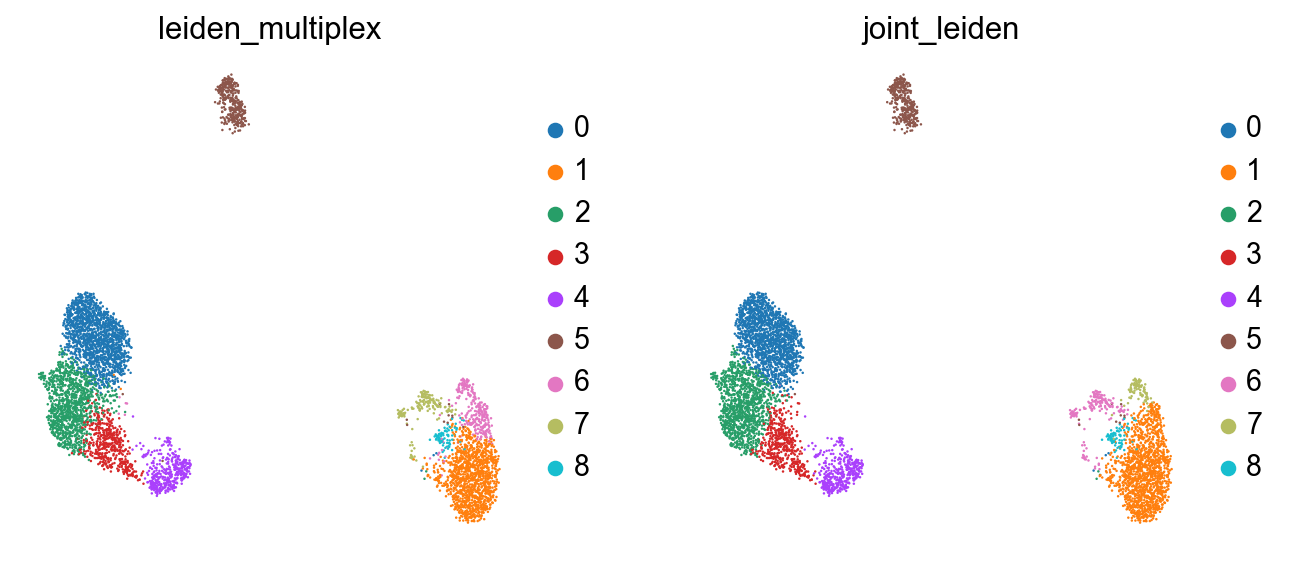

In [30]:
sc.pl.umap(rna, color=["leiden_multiplex", "joint_leiden"], size=5)

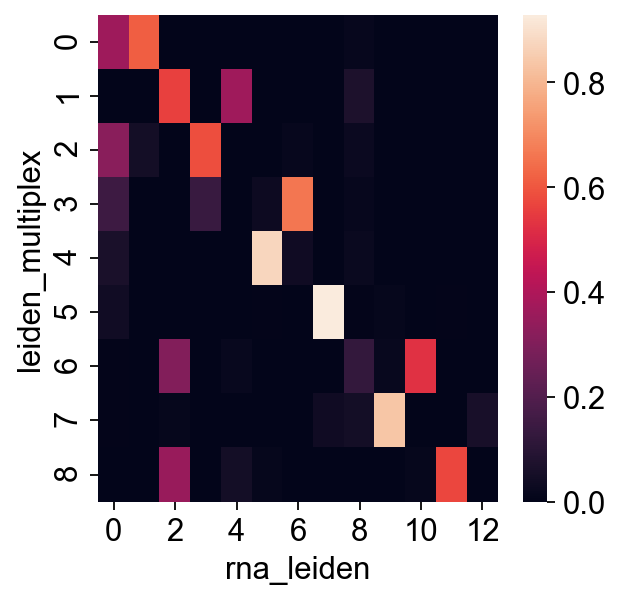

In [31]:
sns.heatmap(pd.crosstab(rna.obs["leiden_multiplex"], rna.obs["rna_leiden"], normalize="index"))

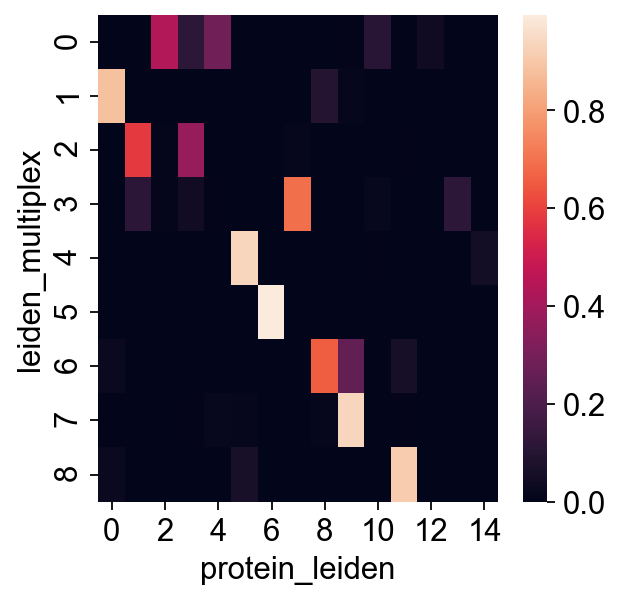

In [32]:
sns.heatmap(pd.crosstab(rna.obs["leiden_multiplex"], rna.obs["protein_leiden"], normalize="index"))